In [1]:
import requests
import json
import os
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_context("poster")
sns.set(rc={"figure.figsize": (17.,6.)})
sns.set_style("whitegrid")

In [13]:
te = pd.read_csv('/home/julian/Cursos/Ironhack/Proyectos/Proyecto2/temperature.csv')

In [5]:
nulls = [te[i].isna().value_counts() for i in te.columns]

In [6]:
print(nulls[2])

False    45252
True         1
Name: Portland, dtype: int64


### eliminamos columnas inecesarias (solo usa y canada)

In [14]:
def keep_columns(x, y):
    """
    Toma como argumento la lista de las columnas que quiero conservar y el nombre del data frame.
    Recorre el indice de columnas del data frame correspondiente y elimina las
    columnas que no quiero conservar
    """
    relevant = x
    for i in y.columns:
        if i not in relevant:
            y.drop(columns=[i], inplace=True)

In [301]:
keep_columns(['datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle',
       'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque',
       'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City',
       'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis',
       'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami',
       'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal',
       'Boston'], te)

### Agrupamos por fecha y max

In [6]:
def agrup_mensual_max(x):
    x['Date'] = x.datetime.apply(lambda y: y[:7])
    return x.groupby("Date").max()

In [7]:
maximas = agrup_mensual_max(te)

In [8]:
keep_columns(['Vancouver', 'Portland', 'Los Angeles', 'Phoenix', 'Denver', 'Dallas', 'Houston', 'Minneapolis',
              'Saint Louis', 'Chicago', 'Atlanta', 'Detroit', 'Charlotte', 'Miami', 'Toronto', 'Philadelphia', 
              'New York', 'Montreal', 'Boston'], maximas)

In [9]:
def celsius_conv(row):
    for i in maximas.index:
           row[i] = row[i] - 273.15
    return row

In [10]:
tempmax = maximas.apply(lambda row : celsius_conv(row))

In [11]:
tempmax = tempmax.reset_index()

In [12]:
tempmax.head()

,Date,Vancouver,Portland,Los Angeles,Phoenix,Denver,Dallas,Houston,Minneapolis,Saint Louis,Chicago,Atlanta,Detroit,Charlotte,Miami,Toronto,Philadelphia,New York,Montreal,Boston
0,2012-10,19.94,27.40,34.56,38.86,26.38,30.52,31.60,25.0200,28.07,25.85,27.17,24.32,27.56,31.14,20.05,25.45,26.63,20.75,24.79
1,2012-11,13.63,20.55,32.86,31.42,22.97,30.20,30.41,18.4200,26.05,20.90,25.88,19.48,22.27,27.75,17.48,20.52,19.16,17.41,19.87
2,2012-12,10.97,14.63,23.15,26.16,20.76,27.12,28.11,11.9600,22.75,21.18,22.12,15.60,22.79,28.89,12.83,18.63,16.92,11.00,14.38
3,2013-01,7.30,13.53,25.54,25.77,17.00,24.83,25.57,4.4975,19.13,14.00,22.86,14.38,22.39,27.36,13.44,16.24,13.12,5.85,15.33
4,2013-02,9.58,15.02,26.29,25.34,16.26,25.65,25.97,3.7900,14.63,10.95,18.21,8.44,17.41,28.71,8.74,15.28,12.63,5.70,11.84


### Agrupamos por fecha y std

In [15]:
def agrup_mensual_std(x):
    x['Date'] = x.datetime.apply(lambda y: y[:7])
    return x.groupby("Date").std()

In [16]:
volat = agrup_mensual_std(te)

In [17]:
keep_columns(['Vancouver', 'Los Angeles', 'Denver', 'Houston', 'Chicago', 'Atlanta', 'Miami',
              'Toronto', 'New York', 'Montreal'], volat)

In [18]:
volat = volat.reset_index()

In [19]:
volat.tail(3)

,Date,Vancouver,Los Angeles,Denver,Houston,Chicago,Atlanta,Miami,Toronto,New York,Montreal
59,2017-09,4.370819,4.756090,7.054063,3.884757,5.833326,4.709246,2.214724,5.385918,4.308954,5.423337
60,2017-10,2.727878,5.448868,7.026114,6.182842,6.374712,6.636940,2.742804,5.168463,5.129633,4.758615
61,2017-11,NaN,4.195282,6.680985,5.759815,4.515401,5.641955,NaN,4.508745,NaN,5.444627


### Agrupamos por fecha y mediana

In [51]:
def agrup_mensual(x):
    x['Date'] = x.datetime.apply(lambda y: y[:7])
    return x.groupby("Date").median()

In [52]:
tem = agrup_mensual(te)

### transformamos a celsius

In [53]:
def celsius_conv(row):
    for i in tem.index:
           row[i] = row[i] - 273.15
    return row

In [54]:
temc = tem.apply(lambda row : celsius_conv(row))

In [55]:
temc = temc.reset_index()

In [ ]:
temc.head()

### Repetimos proceso con datos de humedad

In [181]:
h = pd.read_csv('/home/julian/Cursos/Ironhack/Proyectos/Proyecto2/humidity.csv')

In [136]:
keep_columns(['datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle',
       'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque',
       'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City',
       'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis',
       'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami',
       'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal',
       'Boston'], h)

In [137]:
hm = agrup_mensual(h)

In [138]:
hm = hm.reset_index()

In [182]:
def agrup_mensual_std(x):
    x['Date'] = x.datetime.apply(lambda y: y[:7])
    return x.groupby("Date").std()

In [183]:
volath = agrup_mensual_std(h)

In [184]:
keep_columns(['Vancouver', 'Los Angeles', 'Denver', 'Houston', 'Chicago', 'Atlanta', 'Miami',
              'Toronto', 'New York', 'Montreal'], volath)

In [185]:
volath = volath.reset_index()

In [186]:
volath.head(5)

,Date,Vancouver,Los Angeles,Denver,Houston,Chicago,Atlanta,Miami,Toronto,New York,Montreal
0,2012-10,18.544506,22.775533,25.752651,19.670163,16.416941,19.915979,12.227600,20.747064,16.664269,19.591535
1,2012-11,12.402570,25.506403,18.945381,21.260928,14.140879,22.183199,14.285621,15.972836,15.183803,14.989098
2,2012-12,7.660677,22.650559,22.943808,20.750214,12.556984,19.265463,15.045459,12.284220,18.503020,11.553214
3,2013-01,13.811439,25.151570,23.175068,16.616072,16.774980,21.561284,12.071668,14.988068,20.154328,17.147794
4,2013-02,11.746781,20.652484,24.614792,21.310556,15.176290,24.888481,16.245738,13.350257,19.275873,16.487257


### Obtengo los datos de la API

In [108]:
def get_carbon_data(url):
    url = f"{url}"
    headers = {
    'x-rapidapi-host': "daily-atmosphere-carbon-dioxide-concentration.p.rapidapi.com",
    'x-rapidapi-key': "6f91c81d8fmshc83b86b1b6c6c5cp108956jsnef221ca08c9a"
    }
    response = requests.request("GET", url, headers=headers)
    t = response.json()
    c = pd.DataFrame(t['co2'])
    return c

In [163]:
c = get_carbon_data('https://daily-atmosphere-carbon-dioxide-concentration.p.rapidapi.com/api/co2-api')

#### Creamos cd con todos los años para analizar dsp

In [91]:
def cod_agrupado(x):
    return x.groupby(["year", "month"]).agg({"cycle": "median"})

In [162]:
cd = cod_agrupado(c)

NameError: name 'cod_agrupado' is not defined

#### Escalamos a cd para que tenga solo los años que nos interesan

In [164]:
dates = pd.period_range(start='2011-01-01', end='2021-08-28', freq='D')

In [165]:
c['datetime'] = [str(d) for d in dates]

In [166]:
keep_columns(['datetime', 'cycle'], c)

In [167]:
def agrup_mensual_co2(x):
    x['Date'] = x.datetime.apply(lambda y: y[:7])
    return x.groupby("Date").agg({"cycle": "median"})

In [168]:
co2 = agrup_mensual_co2(c)

In [169]:
co2 = co2.reset_index()

#### CHPPED CO2

In [170]:
cco2 = agrup_mensual_co2(c)

In [171]:
cco2 = cco2.reset_index()

In [172]:
for i in range(83, 128):
    cco2.drop([i], axis=0, inplace=True)
for i in range(21):
    cco2.drop([i], axis=0, inplace=True)

### Unimos temperatura con carbono

In [ ]:
tyc = temc.set_index('Date').join(co2.set_index('Date'))

In [57]:
tyc = tyc.reset_index()

### Unimos humedad con carbono

In [139]:
hyc = hm.set_index('Date').join(co2.set_index('Date'))

In [140]:
hyc = hyc.reset_index()

### GRAFICOS

### Este de aca abajo hacerlo para 3 ciudades mas y mostrar que el set no refleja aumento de temp

<ipython-input-207-ecc4047b8662>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  f.set_xticklabels(labels=tyc["Date"], rotation=60);


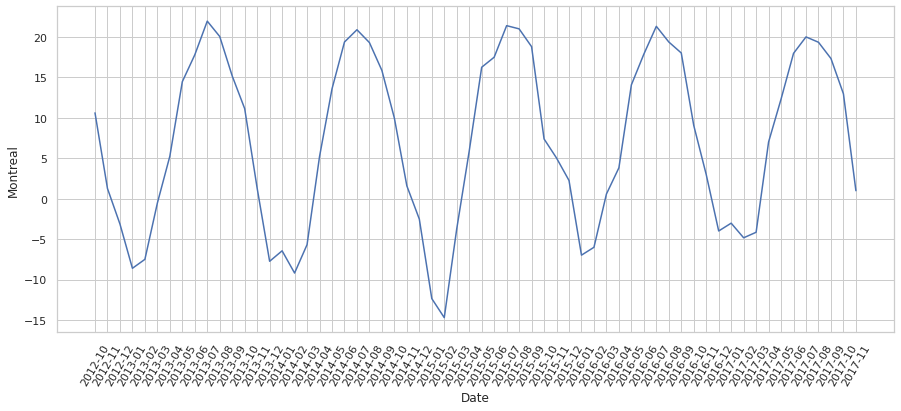

In [207]:
f = sns.lineplot(data=tyc, x="Date", y="Montreal")
f.set_xticklabels(labels=tyc["Date"], rotation=60);

<ipython-input-64-7adf0d4c1460>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.scatterplot(x="Date", y="cycle", hue="Los Angeles", data=tyc, ax=axs[2]).set_xticklabels(labels=tyc["Date"], rotation=60);


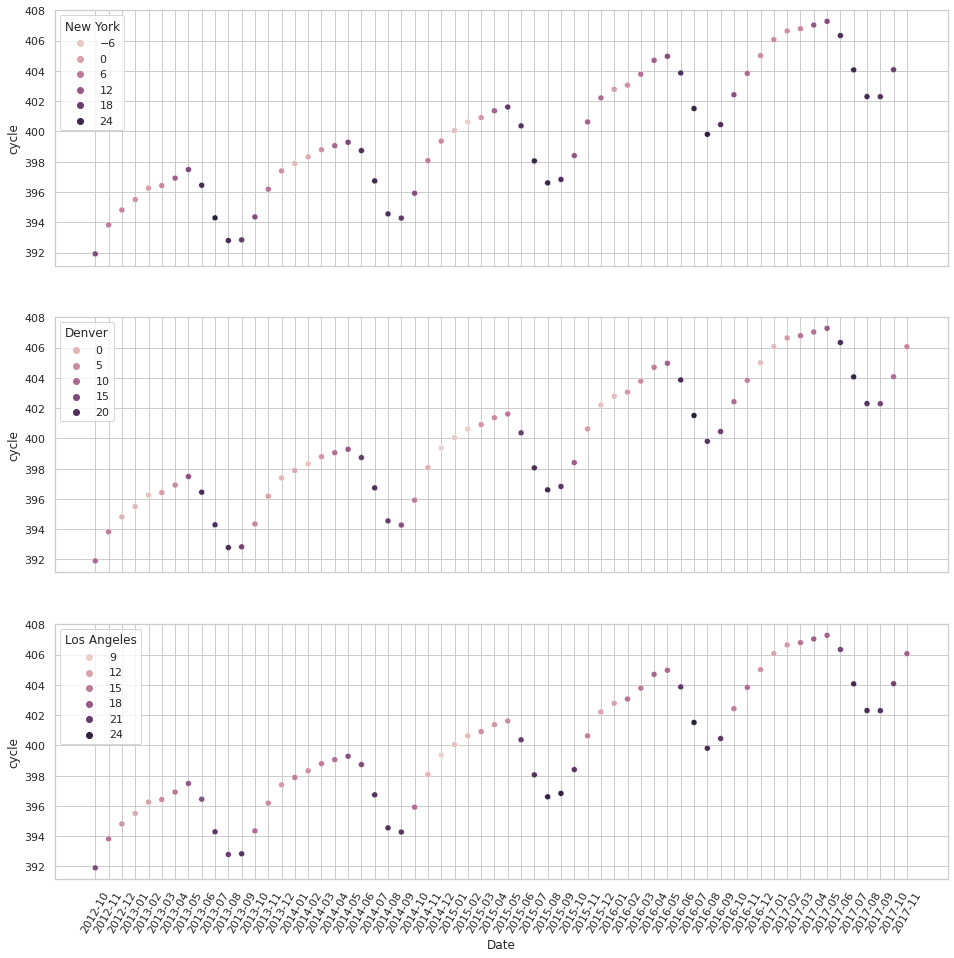

In [64]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(16, 16))
sns.scatterplot(x="Date", y="cycle", hue="New York", data=tyc, ax=axs[0])
sns.scatterplot(x="Date", y="cycle", hue="Denver", data=tyc, ax=axs[1])
sns.scatterplot(x="Date", y="cycle", hue="Los Angeles", data=tyc, ax=axs[2]).set_xticklabels(labels=tyc["Date"], rotation=60);

### Este de abajo hacerlo con tods las fechas del co2

<ipython-input-174-d8e7eab17242>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  f.set_xticklabels(labels=co2["Date"], rotation=75);


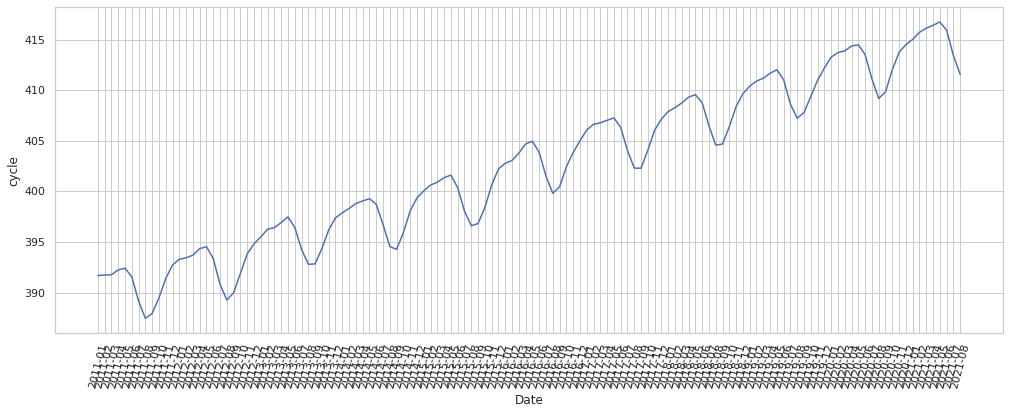

In [174]:
f = sns.lineplot(data=co2, x="Date", y="cycle")
f.set_xticklabels(labels=co2["Date"], rotation=75);

### Variabilidad temp vs co2

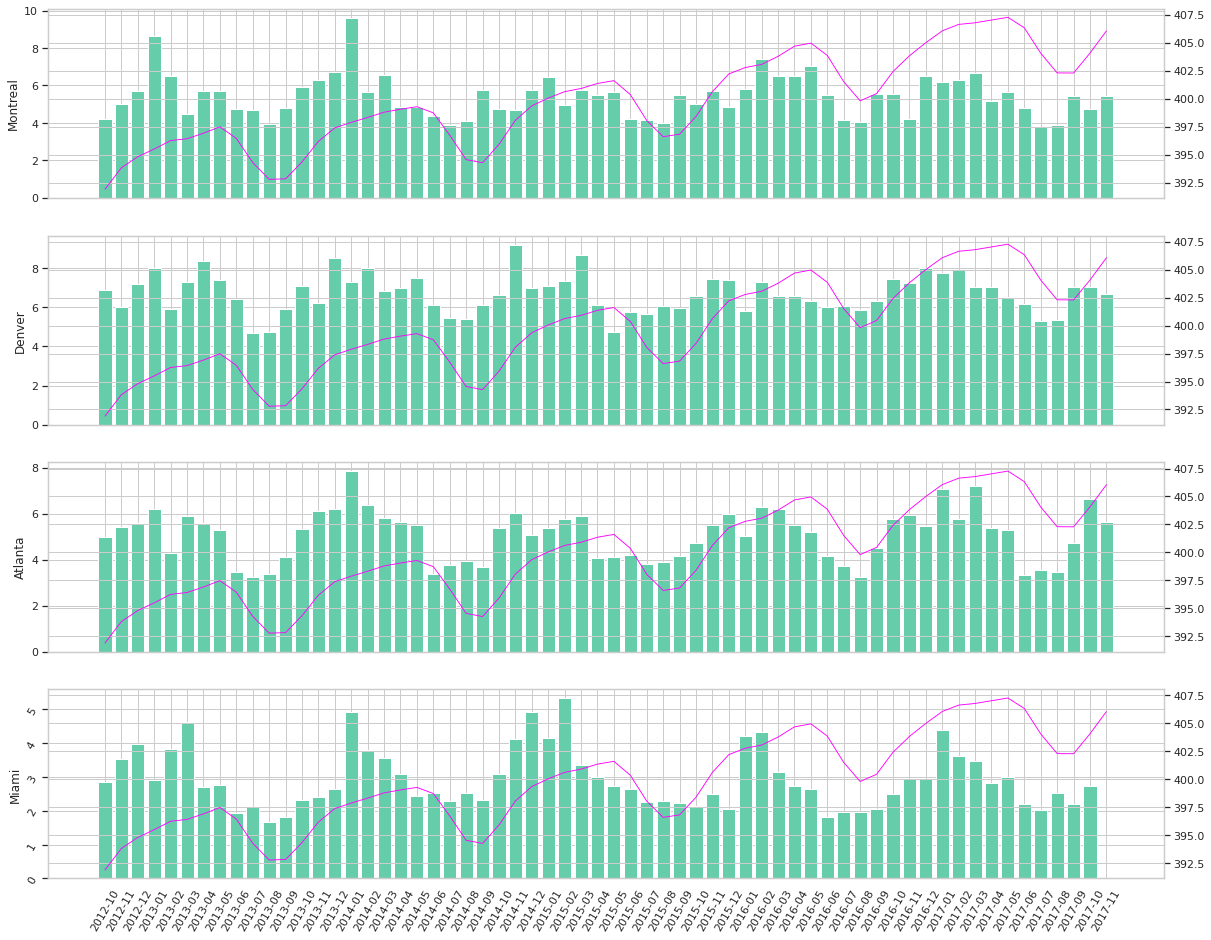

In [179]:
fig, ((x1, x2, x3, x4)) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(20, 16))

x1.bar(volat.Date, volat.Montreal, color="mediumaquamarine")
x1.set_ylabel('Montreal')
x2.bar(volat.Date, volat.Denver, color="mediumaquamarine")
x2.set_ylabel('Denver')
x3.bar(volat.Date, volat.Atlanta, color="mediumaquamarine")
x3.set_ylabel('Atlanta')
x4.bar(volat.Date, volat.Miami, color="mediumaquamarine")
x4.set_ylabel('Miami')

b = x1.twinx()
b.plot(cco2.Date, cco2.cycle, linewidth = 0.9, color="fuchsia")

b = x2.twinx()
b.plot(cco2.Date, cco2.cycle, linewidth = 0.9, color="fuchsia")

b = x3.twinx()
b.plot(cco2.Date, cco2.cycle, linewidth = 0.9, color="fuchsia")

b = x4.twinx()
b.plot(cco2.Date, cco2.cycle, linewidth = 0.9, color="fuchsia")

x4.tick_params(labelrotation=60);

### Variabilidad hume vs co2

''

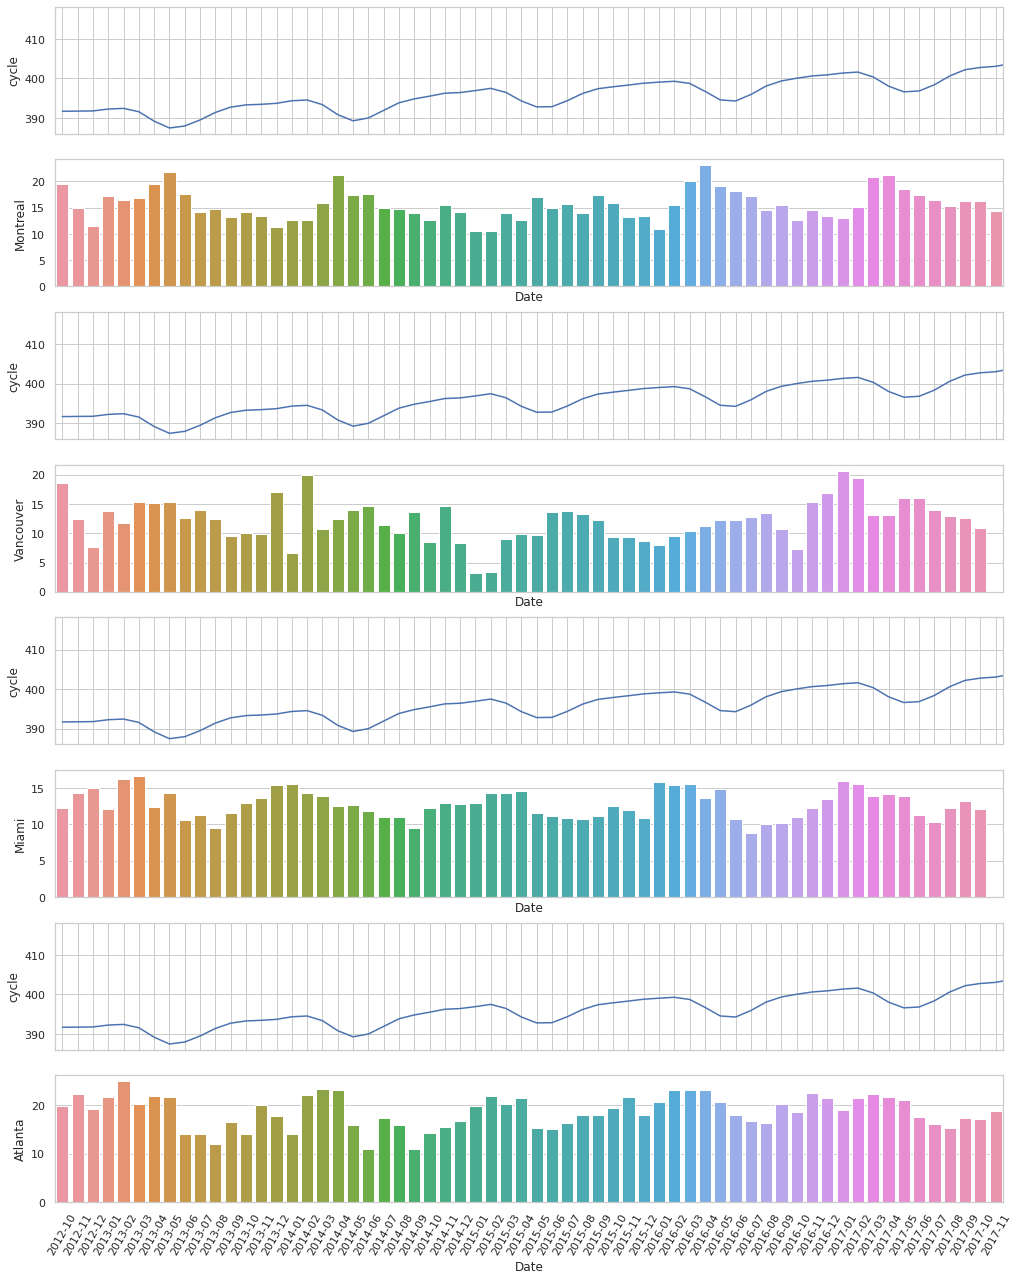

In [175]:
fig, axs = plt.subplots(nrows=8, ncols=1, sharex=True, figsize=(17, 22))

sns.lineplot(x="Date", y="cycle", data=co2, ax=axs[0])

sns.barplot(x="Date", y="Montreal", data=volath, ax=axs[1])

sns.lineplot(x="Date", y="cycle", data=co2, ax=axs[2])

sns.barplot(x="Date", y="Vancouver", data=volath, ax=axs[3])

sns.lineplot(x="Date", y="cycle", data=co2, ax=axs[4])

sns.barplot(x="Date", y="Miami", data=volath, ax=axs[5])

sns.lineplot(x="Date", y="cycle", data=co2, ax=axs[6])

sns.barplot(x="Date", y="Atlanta", data=volath, ax=axs[7]).set_xticklabels(labels=volath["Date"], rotation=60)
;

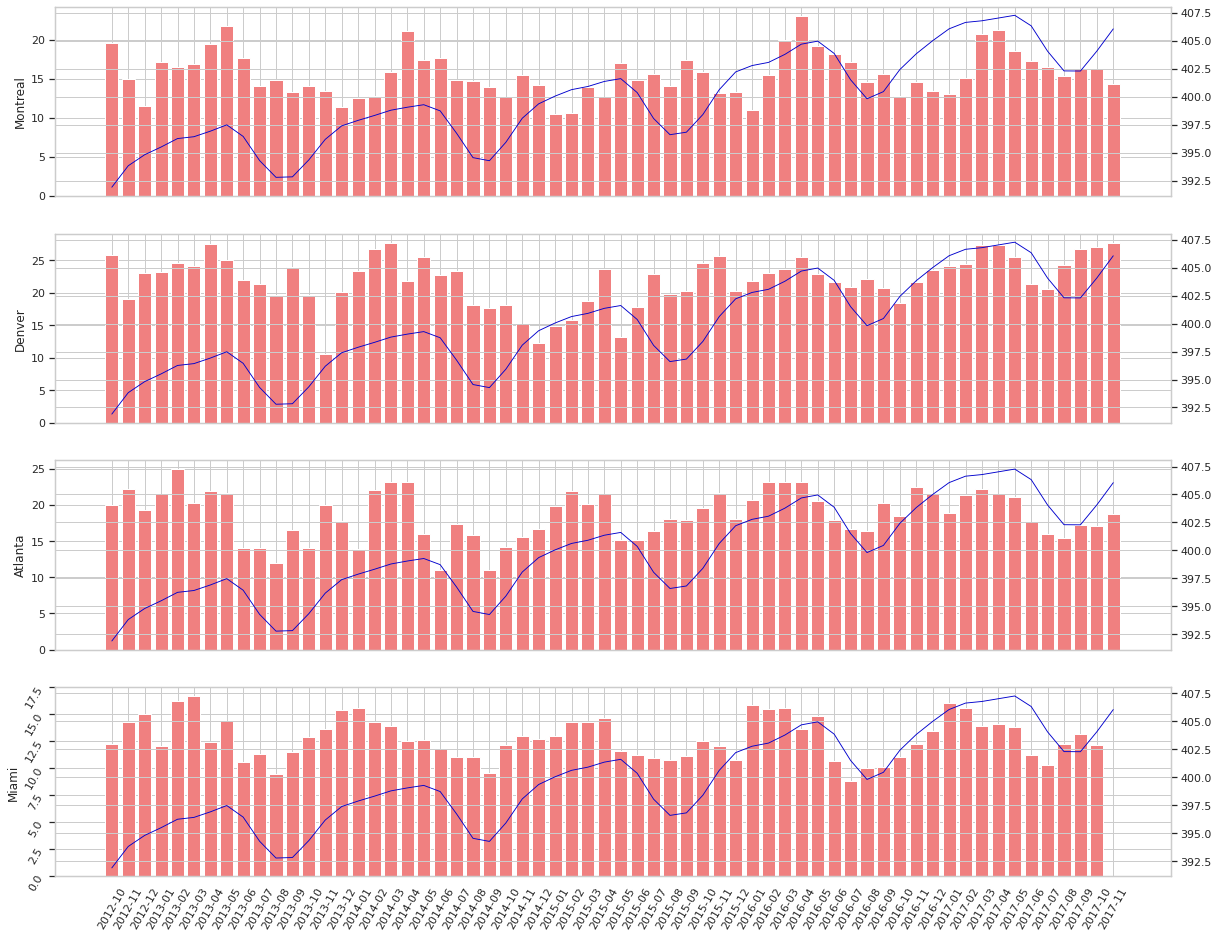

In [187]:
fig, ((x1, x2, x3, x4)) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(20, 16))

x1.bar(volath.Date, volath.Montreal, color="lightcoral")
x1.set_ylabel('Montreal')
x2.bar(volath.Date, volath.Denver, color="lightcoral")
x2.set_ylabel('Denver')
x3.bar(volath.Date, volath.Atlanta, color="lightcoral")
x3.set_ylabel('Atlanta')
x4.bar(volath.Date, volath.Miami, color="lightcoral")
x4.set_ylabel('Miami')

b = x1.twinx()
b.plot(cco2.Date, cco2.cycle, linewidth = 0.9, color="mediumblue")

b = x2.twinx()
b.plot(cco2.Date, cco2.cycle, linewidth = 0.9, color="mediumblue")

b = x3.twinx()
b.plot(cco2.Date, cco2.cycle, linewidth = 0.9, color="mediumblue")

b = x4.twinx()
b.plot(cco2.Date, cco2.cycle, linewidth = 0.9, color="mediumblue")

x4.tick_params(labelrotation=60);